In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [18]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5) #0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


(array([4.82414295e-05, 2.41207147e-05, 1.44724288e-04, 2.89448577e-04,
        2.89448577e-04, 3.13569291e-04, 7.23621442e-04, 1.73669146e-03,
        2.46031290e-03, 4.34172865e-03, 5.76485082e-03, 1.09749252e-02,
        1.40141353e-02, 2.28423168e-02, 3.30936206e-02, 5.01469659e-02,
        7.12043499e-02, 9.98838797e-02, 1.38645868e-01, 1.81797827e-01,
        2.33126708e-01, 2.92511907e-01, 3.46228739e-01, 3.90128440e-01,
        4.21099438e-01, 4.23656233e-01, 4.06771733e-01, 3.64584603e-01,
        3.14389396e-01, 2.58791148e-01, 2.03385867e-01, 1.53480108e-01,
        1.15900034e-01, 8.28546551e-02, 6.06153561e-02, 4.07640079e-02,
        2.77147012e-02, 1.81387775e-02, 1.19397538e-02, 7.76687014e-03,
        4.77590152e-03, 2.99096863e-03, 1.56784646e-03, 1.06131145e-03,
        6.75380012e-04, 1.68845003e-04, 1.68845003e-04, 7.23621442e-05,
        0.00000000e+00, 7.23621442e-05]),
 array([-5.22762346, -5.02033276, -4.81304205, -4.60575134, -4.39846064,
        -4.19116993, 

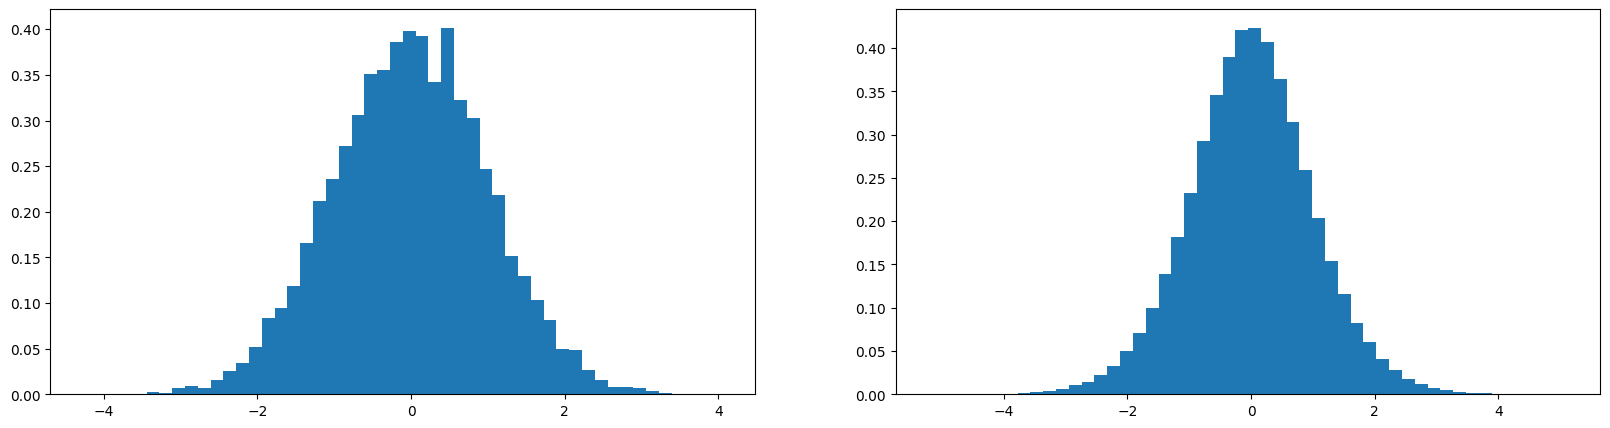

In [23]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5
y = x @ w
plt.figure(figsize=(20, 5))
plt.subplot(121)
x_temp = x.view(-1).tolist()
y_temp = y.view(-1).tolist()
plt.hist(x_temp, bins=50, density=True)
plt.subplot(122)
plt.hist(y_temp, bins=50, density=True )


In [24]:
# same optimization as last time
max_steps = 50000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = (hpreact - bnmeani)/(bnstdi) * bngain + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break

      0/  50000: 3.3147
  10000/  50000: 2.1984
  20000/  50000: 2.3375
  30000/  50000: 2.4359
  40000/  50000: 2.0119


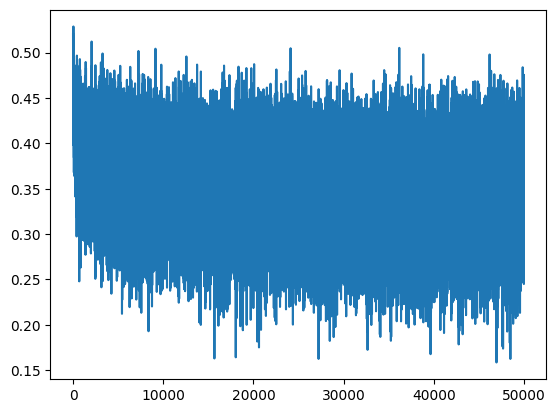

In [25]:
plt.plot(lossi)

In [26]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through 
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1
  # measure the mean/std over the entire training set 
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [27]:
bnmean

tensor([[-1.7624,  0.5206, -1.0960,  1.0316,  1.1369,  0.5361,  1.5657, -1.6521,
          0.7068,  1.4808, -1.3817, -2.0189, -0.3564, -0.2288, -0.4152, -0.6883,
          0.6496, -2.1125, -0.3464,  1.5010, -0.3047, -0.0289,  0.0771,  0.3928,
          1.0585,  0.2657,  1.0192,  0.1136,  0.3042,  1.2661, -0.5612, -1.0511,
         -0.0349, -0.1367, -0.1772, -1.0962, -0.3013,  0.1565, -0.5010,  0.6224,
         -0.2151, -0.9304, -0.3801,  0.0683,  0.8268,  0.3333,  1.2534, -0.3326,
          1.9779,  1.4501,  0.7846,  0.0448,  1.6337,  0.8395,  0.7625, -1.5354,
         -0.2963,  0.4061,  1.1146, -1.1462, -0.2654,  0.8594,  0.4499,  0.2556,
          1.2279,  1.0222, -0.7397,  1.1800, -0.3995,  0.0770, -0.2716,  0.2652,
          0.8187, -1.0350, -2.2853,  0.2371,  0.9237, -0.0677,  0.2684,  0.5816,
          0.4125,  1.1334,  1.3819,  0.7226,  0.6297, -0.3460, -1.3493,  0.4730,
          1.5639, -0.3056, -0.9342,  0.8510, -0.6452, -0.5049, -0.8383,  0.3206,
          0.0027, -0.2948,  

In [28]:
bnmean_running

tensor([[-1.7400e+00,  4.9252e-01, -1.0848e+00,  1.0079e+00,  1.1762e+00,
          5.9179e-01,  1.6040e+00, -1.6239e+00,  6.9097e-01,  1.4951e+00,
         -1.4003e+00, -2.0149e+00, -4.2615e-01, -2.8036e-01, -3.7461e-01,
         -6.6720e-01,  6.5961e-01, -2.0734e+00, -3.4279e-01,  1.5043e+00,
         -2.9410e-01, -2.9482e-02,  2.1704e-02,  3.8105e-01,  9.8683e-01,
          2.8864e-01,  1.0686e+00,  8.8826e-02,  3.2782e-01,  1.2695e+00,
         -5.2154e-01, -9.9342e-01,  9.3221e-04, -1.6234e-01, -2.0968e-01,
         -1.1097e+00, -3.0442e-01,  1.5252e-01, -4.7094e-01,  6.4434e-01,
         -1.7183e-01, -8.8792e-01, -4.1587e-01,  7.4013e-02,  8.1724e-01,
          3.6042e-01,  1.2680e+00, -3.0503e-01,  2.0198e+00,  1.4452e+00,
          7.7213e-01,  8.3927e-03,  1.5358e+00,  8.8255e-01,  7.5705e-01,
         -1.6162e+00, -2.6494e-01,  3.8247e-01,  1.1136e+00, -1.1465e+00,
         -3.1863e-01,  8.1758e-01,  4.4175e-01,  2.7669e-01,  1.2665e+00,
          9.8390e-01, -7.3868e-01,  1.

In [62]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = (hpreact - bnmean)/(bnstd) * bngain + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


In [16]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)



out = []
context = [0] * block_size # initialize with all ...
while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
        break

print(''.join(itos[i] for i in out))

briangmyazziyes.


In [1]:
### SUMMARY -------

In [50]:
# lets train a deeper network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training=True
        # parameters (training without backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers 
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    
    def __call__(self, x):
        # calculate the forward pass 
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance

        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out
                    
    def parameters(self):
        return [self.gamma, self.beta]



class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out 
    
    def parameters(self):
        return []

n_embd = 10      # the dimeansionality of the character embeddings vector
n_hidden = 100  # the number of neurons in the hidden layer of the mlp
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)


layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
#   layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True





47024


In [55]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i == 10000:
    break



      0/ 200000: 2.2269


  10000/ 200000: 1.8825


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 3.75%
layer 5 (      Tanh): mean -0.01, std 0.66, saturated: 4.56%
layer 8 (      Tanh): mean -0.01, std 0.67, saturated: 3.81%
layer 11 (      Tanh): mean +0.00, std 0.67, saturated: 3.19%
layer 14 (      Tanh): mean -0.01, std 0.68, saturated: 3.28%


Text(0.5, 1.0, 'activation distribution')

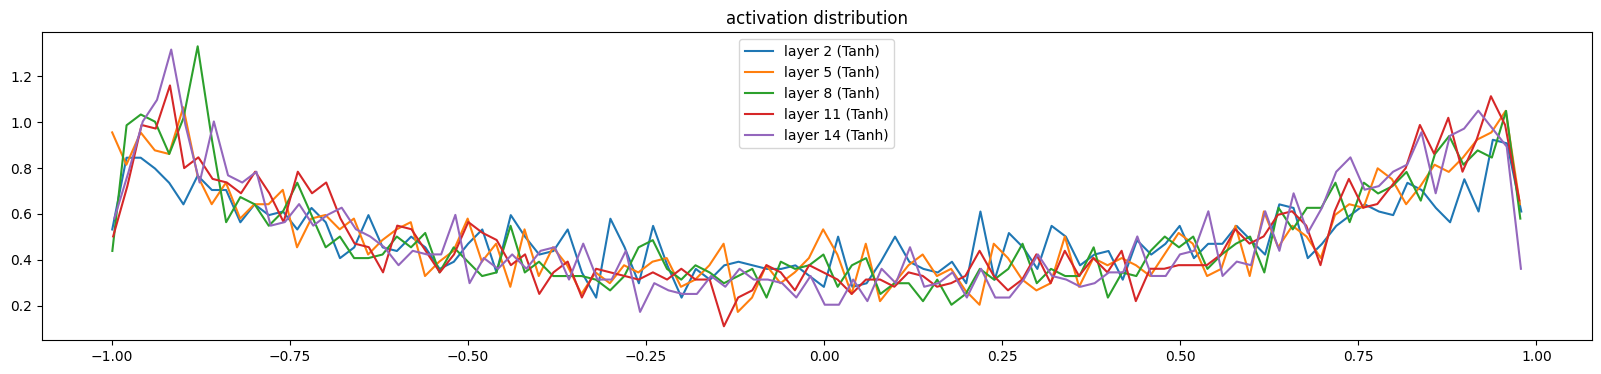

In [56]:
# visualize histograms 
plt.figure(figsize=(20, 4)) # width and height of the plot 
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')    
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00
layer 5 (      Tanh): mean -0.00, std 0.00
layer 8 (      Tanh): mean +0.00, std 0.00
layer 11 (      Tanh): mean +0.00, std 0.00
layer 14 (      Tanh): mean -0.00, std 0.00


Text(0.5, 1.0, 'gradient distribution')

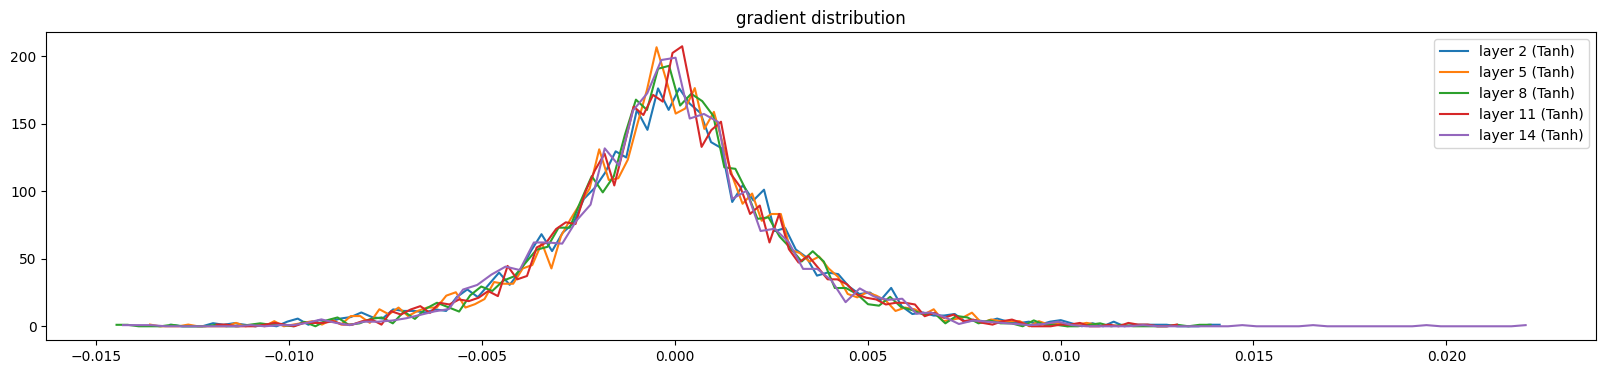

In [57]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+.2f, std %.2f" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 9.561444e-03 | grad:data ratio 9.499115e-03
weight  (30, 100) | mean -0.000220 | std 7.355444e-03 | grad:data ratio 2.276734e-02
weight (100, 100) | mean +0.000036 | std 5.792216e-03 | grad:data ratio 3.236351e-02
weight (100, 100) | mean +0.000016 | std 5.233627e-03 | grad:data ratio 2.937432e-02
weight (100, 100) | mean -0.000011 | std 5.104256e-03 | grad:data ratio 2.891011e-02
weight (100, 100) | mean +0.000063 | std 4.991467e-03 | grad:data ratio 2.845100e-02
weight  (100, 27) | mean -0.000017 | std 9.426044e-03 | grad:data ratio 4.855968e-02


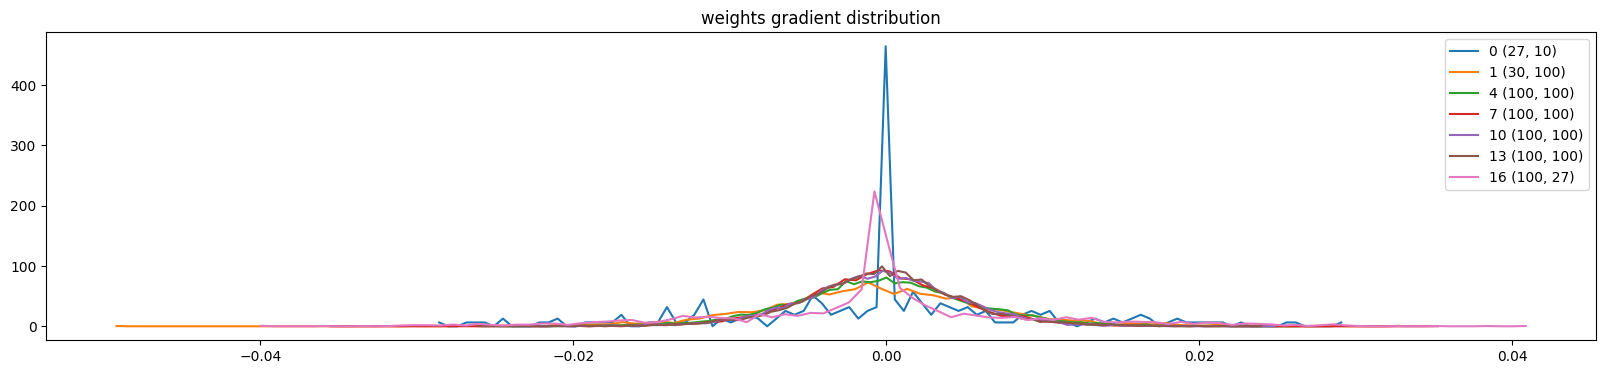

In [58]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');